# LISA lensing rates
* zs, mass_1, mass_2, a_1, a_2 are from the given .dat file
* zs given is considered to be the redshift of the source in detector frame
* detector frame merger rate density will be taken from zs distribution
* source frame merger rate density '$\rho$' (at zs and comoving volume at zs) is calculated using the given redshift and the cosmology,
$$ \frac{\rho}{1+z_s} \frac{dV}{dz}(z_s) dz_s$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ler import LeR
import lisa_snr
import json

# Getting data

In [2]:
# read flash.dat to a list of lists
# this data is from the link https://people.sissa.it/~barausse/catalogs/
datContent = [i.strip().split() for i in open("Klein16_Q3nodelays.dat").readlines()]
datContent = np.array(datContent, dtype='str')
datContent = datContent[:,:5].astype('float')

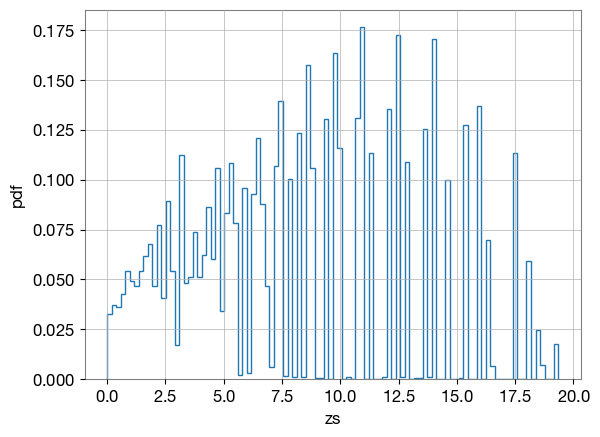

In [3]:
# plot histogram of zs
zs = datContent[:,0]
plt.hist(zs, density=True, histtype='step', bins=100)
#plt.xscale('log')
plt.xlabel('zs')
plt.ylabel('pdf')
plt.show()

# KDE of merger rate density

In [4]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=1.,kernel='gaussian')
kde.fit(zs[:, np.newaxis])

KernelDensity()

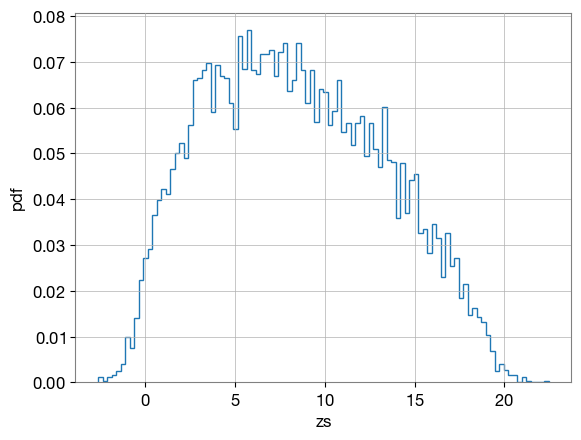

In [5]:
# sampling from the kde
zs_ = kde.sample(10000)
plt.hist(zs_, density=True, histtype='step', bins=100)
#plt.xscale('log')
plt.xlabel('zs')
plt.ylabel('pdf')
plt.show()

In [6]:
# putting in a functional form 
def pdf(z):
    z = np.array([z]).reshape(-1)
    return np.exp(kde.score_samples(z[:,np.newaxis]))

In [7]:
# 1D interpolatio for fast calculation
from scipy.interpolate import interp1d
z_min = 0.
z_max = 20.
z = np.linspace(z_min, z_max, 500)  # redshift
rho =  pdf(z)
merger_rate_density = interp1d(z, rho, kind="cubic")

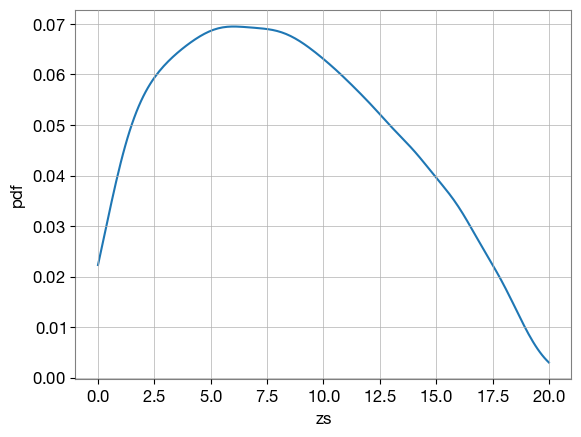

In [8]:
# kde function
zs = np.linspace(0,20,200)[:, np.newaxis]
plt.plot(zs, merger_rate_density(zs) )
plt.xlabel('zs')
plt.ylabel('pdf')
plt.show()

# LeR initialization

## POP I II

In [9]:
# for popI_II
ler_pop = LeR(z_max=20.0)

Given: IMR waveform, {self.waveform_approximant}.
psds not given. Choosing bilby's default psds
given psds:  {'L1': 'aLIGO_O4_high_asd.txt', 'H1': 'aLIGO_O4_high_asd.txt', 'V1': 'AdV_asd.txt'}
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/halfSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/halfSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/halfSNR_dict_0.pickle


In [10]:
# redshift distribution of source
zs_pop = ler_pop.compact_binary_pop.sample_source_redshifts(size=1000, z_min=0.0, z_max=20.0)

## MBHB

In [11]:
# note that snr from gwsnr will be replaced by lisa_snr
# for mbhb
ler_mbhb = LeR(z_max=20.0, merger_rate_density_fn=merger_rate_density)

Given: IMR waveform, {self.waveform_approximant}.
psds not given. Choosing bilby's default psds
given psds:  {'L1': 'aLIGO_O4_high_asd.txt', 'H1': 'aLIGO_O4_high_asd.txt', 'V1': 'AdV_asd.txt'}
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/halfSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/halfSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/halfSNR_dict_0.pickle


In [12]:
# redshift distribution of source
zs_mbhb = ler_mbhb.compact_binary_pop.sample_source_redshifts(size=1000, z_min=0.0, z_max=20.0)

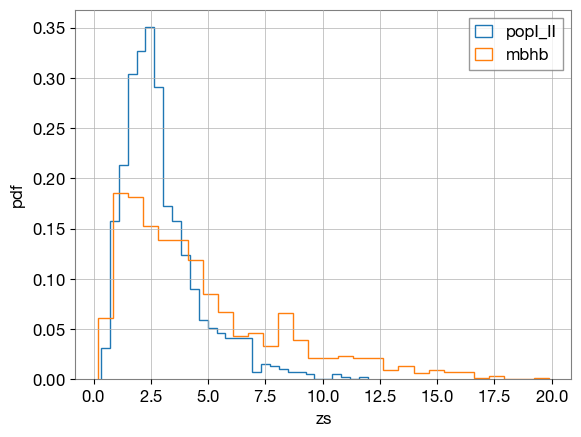

In [50]:
# plot histogram of zs
plt.hist(zs_pop, density=True, histtype='step', bins=30, label='popI_II')
plt.hist(zs_mbhb, density=True, histtype='step', bins=30, label='mbhb')
#plt.xscale('log')
plt.xlabel('zs')
plt.ylabel('pdf')
plt.legend()
plt.show()

## unlensed case

In [57]:
unlensed_params = ler_mbhb.unlensed_cbc_statistics(nsamples=100000, json_file="lisa_unlensed_params.json",resume=False)
print(unlensed_params.keys())

chosen batch size = 25000. If you want to change batch size, self.batch_size = new_size
There will be 4 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
Batch no. 2
sampling gw source params...
calculating snrs...
Batch no. 3
sampling gw source params...
calculating snrs...
Batch no. 4
sampling gw source params...
calculating snrs...
dict_keys(['mass_1', 'mass_2', 'mass_1_source', 'mass_2_source', 'zs', 'luminosity_distance', 'iota', 'psi', 'phase', 'geocent_time', 'ra', 'dec', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'opt_snr_net', 'L1', 'H1', 'V1'])


In [58]:
# for replacing some data with the given data from .dat file
num = 100000
mass_1 = np.random.choice(datContent[:,1], size=num, replace=False)
mass_2 = np.random.choice(datContent[:,2], size=num, replace=False)
a_1 = np.random.choice(datContent[:,3], size=num, replace=False)
a_2 = np.random.choice(datContent[:,4], size=num, replace=False)

idx = mass_2>mass_1
mass_1[idx], mass_2[idx] = mass_2[idx], mass_1[idx]

unlensed_params['mass_1_source'] = mass_1
unlensed_params['mass_2_source'] = mass_2
unlensed_params['mass_1'] = mass_1*(1+unlensed_params['zs'])
unlensed_params['mass_2'] = mass_2*(1+unlensed_params['zs'])
#unlensed_params['luminosity_distance'] = ler_.z_to_luminosity_distance(unlensed_params['zs'])
unlensed_params['a_1'] = a_1
unlensed_params['a_2'] = a_2

# setting up the GWparam_dict for lisa_snr function
GWparam_dict = {}
GWparam_dict['mass_1'] = unlensed_params['mass_1']
GWparam_dict['mass_2'] = unlensed_params['mass_2']
GWparam_dict['luminosity_distance'] = unlensed_params['luminosity_distance']
GWparam_dict['iota'] = unlensed_params['iota']
GWparam_dict['psi'] = unlensed_params['psi']
GWparam_dict['phase'] = unlensed_params['phase']
GWparam_dict['Deltat'] = unlensed_params['geocent_time']
GWparam_dict['longitude'] = 0.8*np.ones(num)
GWparam_dict['latitude'] = 0.3*np.ones(num)
GWparam_dict['a_1'] = unlensed_params['a_1']
GWparam_dict['a_2'] = unlensed_params['a_2']

In [59]:
# computing snr with lisa_snr
lisa_ = lisa_snr.LISA_SNR() # initializing the class
snr_lisa = lisa_.snr_mp(GWparam_dict=GWparam_dict)

100%|██████████████████████████████████████████████████████| 100000/100000 [02:34<00:00, 647.68it/s]


In [60]:
# replace snr in unlensed_params with snr_lisa
unlensed_params['opt_snr_net'] = snr_lisa

# saving the unlensed_params to a json file for later use
from ler.helperroutines import append_json
append_json(file_name="lisa_unlensed_params.json", dictionary=unlensed_params, replace=True)

In [61]:
# computing the unlensed rates
unlensed_rates = ler_mbhb.unlensed_rate(gw_param=unlensed_params, jsonfile="lisa_unlensed_params_detectable.json")

storing detectable unlensed params in lisa_unlensed_params_detectable.json
total unlensed rate with step function: 47570256557.84782
total unlensed rate with pdet function: 47576685539.69684


## lensed case

In [64]:
lensed_params = ler_mbhb.lensed_cbc_statistics(nsamples=100000, resume=False)

chosen batch size = 25000. If you want to change batch size, self.batch_size = new_size
There will be 4 batche(s)
Batch no. 1
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 25000/25000 [00:18<00:00, 1330.32it/s]


calculating snrs...
Batch no. 2
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 25000/25000 [00:16<00:00, 1524.88it/s]


calculating snrs...
Batch no. 3
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 25000/25000 [00:16<00:00, 1474.90it/s]


calculating snrs...
Batch no. 4
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 25000/25000 [00:16<00:00, 1524.89it/s]


calculating snrs...


In [65]:
lensed_params.keys()

dict_keys(['zl', 'zs', 'sigma', 'q', 'e1', 'e2', 'gamma1', 'gamma2', 'Dl', 'Ds', 'Dls', 'theta_E', 'gamma', 'mass_1', 'mass_2', 'mass_1_source', 'mass_2_source', 'luminosity_distance', 'iota', 'psi', 'phase', 'geocent_time', 'ra', 'dec', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'n_images', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'weights', 'opt_snr_net', 'L1', 'H1', 'V1'])

In [66]:
# for replacing some data with the given data from .dat file
lensed_params["mass_1_source"] = mass_1
lensed_params["mass_2_source"] = mass_2
lensed_params["mass_1"] = mass_1*(1+lensed_params['zs'])
lensed_params["mass_2"] = mass_2*(1+lensed_params['zs'])
#lensed_params["luminosity_distance"] = ler_.z_to_luminosity_distance(lensed_params['zs'])
lensed_params["a_1"] = a_1
lensed_params["a_2"] = a_2

# setting up the GWparam_dict for lisa_snr function
GWparam_dict = {}
GWparam_dict['mass_1'] = lensed_params['mass_1']
GWparam_dict['mass_2'] = lensed_params['mass_2']
GWparam_dict['luminosity_distance'] = lensed_params['luminosity_distance']
GWparam_dict['iota'] = lensed_params['iota']
GWparam_dict['psi'] = lensed_params['psi']
GWparam_dict['phase'] = lensed_params['phase']
GWparam_dict['Deltat'] = lensed_params['geocent_time']
GWparam_dict['longitude'] = 0.8*np.ones(num)
GWparam_dict['latitude'] = 0.3*np.ones(num)
GWparam_dict['a_1'] = lensed_params['a_1']
GWparam_dict['a_2'] = lensed_params['a_2']
GWparam_dict['magnifications'] = lensed_params['magnifications']
GWparam_dict['time_delays'] = lensed_params['time_delays']



In [67]:
import imp
import lisa_snr
imp.reload(lisa_snr)

<module 'lisa_snr' from '/Users/hemantaph/phd/lisalensing/lisa_snr.py'>

In [68]:
# computing snr with lisa_snr
snr_lisa = lisa_snr.snr_lensed(lisa_snr_class=lisa_snr.LISA_SNR, lensed_param=GWparam_dict, n_max_images=4)

100%|████████████████████████████████████████████████████████| 12227/12227 [00:19<00:00, 627.50it/s]


In [69]:
# replace snr in lensed_params with snr_lisa
lensed_params['opt_snr_net'] = snr_lisa['opt_snr_net']

# saving the lensed_params to a json file for later use
from ler.helperroutines import append_json
append_json(file_name="lisa_lensed_params.json", dictionary=lensed_params, replace=True)

In [70]:
# computing the lensed rates
lensed_rates = ler_mbhb.lensed_rate(lensed_param=lensed_params, jsonfile="lisa_lensed_params_detectable.json")

storing detectable lensed params in lisa_lensed_params_detectable.json...
total lensed rate with step function: 79650905.98775783
total lensed rate with pdet function: 79630363.44095962


In [71]:
# rate comparison
ler_mbhb.rate_comparision(
    unlened_param="lisa_unlensed_params_detectable.json",
    lensed_param="lisa_lensed_params_detectable.json",
)

getting gw_params from json file lisa_unlensed_params_detectable.json...
storing detectable unlensed params in ./gw_params_detectable.json
total unlensed rate with step function: 53517073798.31678
total unlensed rate with pdet function: 53460971597.056526
getting lensed_param from json file lisa_lensed_params_detectable.json...
storing detectable lensed params in ./lensed_params_detectable.json...
total lensed rate with step function: 93427764.07882074
total lensed rate with pdet function: 93247880.22746573
unlensed/lensed rate ratio =  (572.8176664183773, 573.321039219826)


([53517073798.31678, 53460971597.056526],
 [93427764.07882074, 93247880.22746573],
 (572.8176664183773, 573.321039219826))

# redshift plots

In [72]:
# getting data from json

# all
with open("lisa_unlensed_params.json") as f:
    unlensed_params = json.load(f)

with open("lisa_lensed_params.json") as f:
    lensed_params = json.load(f)

# detectable
with open("lisa_unlensed_params_detectable.json") as f:
    unlensed_params_detectable = json.load(f)

with open("lisa_lensed_params_detectable.json") as f:
    lensed_params_detectable = json.load(f)

### all

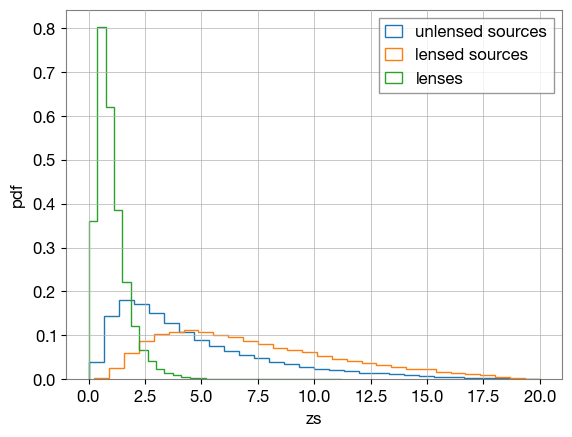

In [73]:
# plot histogram of zs
plt.hist(unlensed_params['zs'], density=True, histtype='step', bins=30, label='unlensed sources')
plt.hist(lensed_params['zs'], density=True, histtype='step', bins=30, label='lensed sources')
plt.hist(lensed_params['zl'], density=True, histtype='step', bins=30, label='lenses')
#plt.xscale('log')
plt.xlabel('zs')
plt.ylabel('pdf')
plt.legend()
plt.show()

# detectable only

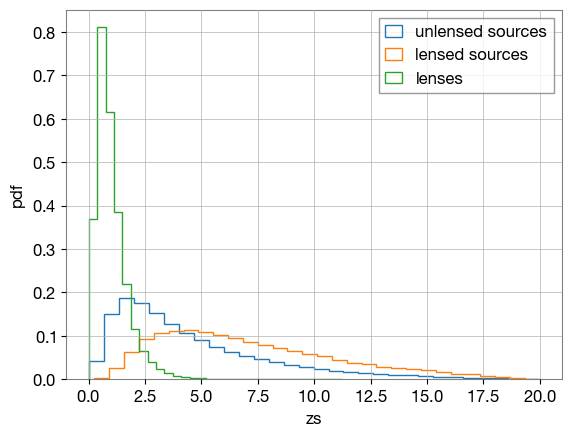

In [74]:
# plot histogram of zs
plt.hist(unlensed_params_detectable['zs'], density=True, histtype='step', bins=30, label='unlensed sources')
plt.hist(lensed_params_detectable['zs'], density=True, histtype='step', bins=30, label='lensed sources')
plt.hist(lensed_params_detectable['zl'], density=True, histtype='step', bins=30, label='lenses')
#plt.xscale('log')
plt.xlabel('zs')
plt.ylabel('pdf')
plt.legend()
plt.show()

In [75]:
print(len(unlensed_params['zs']))
print(len(unlensed_params_detectable['zs']))

100000
88888


* almost all of them are detectable